In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

parent_folder = os.path.dirname(os.path.abspath("./"))
sys.path.append(parent_folder)

import numpy as np

In [2]:
from sklearn.datasets import make_moons
from data._utils import add_noise

def make_moons_random_assignment(n_samples, n_new_dims=0, seed=0):
    np.random.seed(seed)
    X, l = make_moons(n_samples=n_samples, random_state=seed, noise=0.0)
    # X, l = add_noise(X, l, 20, 0.1)
    class0 = np.where(l == 0)[0]
    class1 = np.where(l == 1)[0]
    # choice_class0 = np.random.choice(len(class0), replace=False, size=n_samples // 100 * n_swap)
    # choice_class1 = np.random.choice(len(class1), replace=False, size=n_samples // 100 * n_swap)
    # l[class0[choice_class0]] = 1
    # l[class1[choice_class1]] = 0
    X = np.hstack((X, np.zeros((len(X), n_new_dims))))
    return X, l

### twoMoonsDatasets[n_dims][run]
n_dims = list(range(2, 11, 1))
np.random.seed(0)
random_seeds = np.random.choice(1_000_000, replace=False, size=10)
twoMoonsDatasets = [
    [make_moons_random_assignment(500, n_new_dims=n_dim-2, seed=seed) for seed in random_seeds]
    for n_dim in n_dims
]

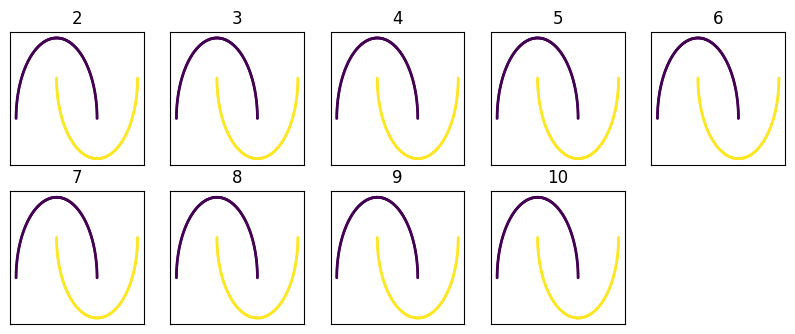

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(2*5, 2*5))
G = gridspec.GridSpec(5, 5)

for n_dim in range(0, len(n_dims)):
    ax = plt.subplot(G[n_dim // 5, n_dim % 5])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{n_dims[n_dim]}")
    X, l = twoMoonsDatasets[n_dim][0]
    plt.scatter(X[:, 0], X[:, 1], s=1, c=l)

In [4]:
import cache_magic

import time
from collections import defaultdict
from data._metrics import METRICS
from data._utils import insert_dict


def calc():
    eval_results = defaultdict(list)

    for n_dim in range(len(twoMoonsDatasets)):
        for run in range(len(twoMoonsDatasets[0])):
            X, l = twoMoonsDatasets[n_dim][run]
            for name, metric_fn in METRICS.items():
                start_time = time.time()
                start_process_time = time.process_time()
                value = metric_fn(X, l)
                end_process_time = time.process_time()
                end_time = time.time()
                insert_dict(eval_results, {
                    "measure": name, 
                    "n_dims": n_dims[n_dim],
                    "run": run,
                    "value": value,
                    "time": end_time - start_time,
                    "process_time": end_process_time - start_process_time,
                })
    return eval_results

%cache eval_results_dims = calc()

%cache magic is now registered in ipython
loading cached value for variable 'eval_results_dims'. Time since pickling  0:20:01.621518


In [5]:
import pandas as pd

SELECTED_MEASURES = [
    "DISCO",
    # "DC_DUNN",
    ### Competitors
    "DBCV",
    "DCSI",
    # "S_DBW",
    "CDBW",
    "CVDD",
    # "CVNN",
    "DSI",
    ### Gauss
    "SILHOUETTE",
    "DUNN",
    # "DB",
    # "CH",
]

df = pd.DataFrame(data=eval_results_dims)
df = df[df.measure.isin(SELECTED_MEASURES)]
df["measure"] = pd.Categorical(df["measure"], SELECTED_MEASURES)
df = df.sort_values("measure")
# df.groupby("measure").sum()

In [6]:
df[(df.measure == "DBCV") & (df.n_dims == 4)]

,measure,n_dims,run,value,time,process_time
379,DBCV,4,9,0.461556,0.092057,2.291432
366,DBCV,4,8,0.461556,0.093485,2.367770
353,DBCV,4,7,0.461556,0.091856,2.292093
327,DBCV,4,5,0.461556,0.092300,2.333027
262,DBCV,4,0,0.461556,0.081103,2.045173
314,DBCV,4,4,0.461556,0.091426,2.348327
340,DBCV,4,6,0.461556,0.083358,2.120804
275,DBCV,4,1,0.461556,0.072808,1.777772
288,DBCV,4,2,0.461556,0.094506,2.302631
301,DBCV,4,3,0.461556,0.060725,1.529737


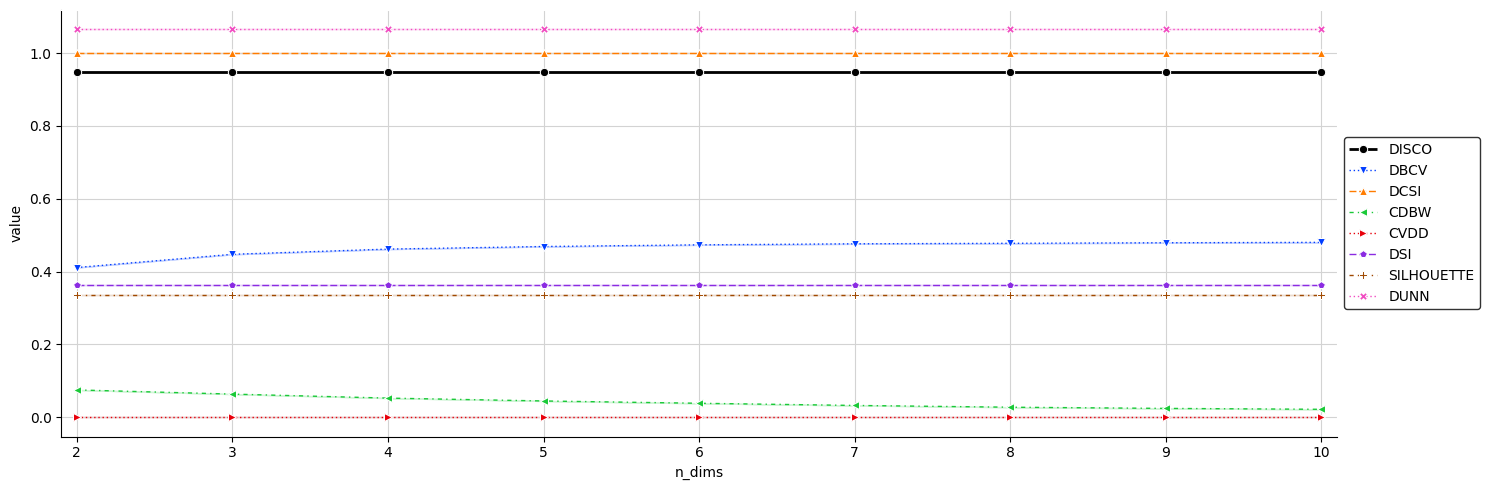

In [7]:
from data._utils import plot_lineplot

eps = 0.1
ymin = n_dims[0] - eps
ymax = n_dims[-1] + eps

plot_lineplot(df, "n_dims", "value", "measure", x_range=(ymin, ymax), y_range=(None, None))
plt.savefig("imgs/TwoMoons_dims.png")